### Non-equilibrium Demography

In [1]:
import subprocess, msprime, pyslim, tskit, os, matplotlib, pickle, random, dadi
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcol
import numpy as np
import pandas as pd
import dadi.DFE as DFE
from dadi.DFE import *
from scipy import stats
from dadi import *
from scipy.stats import norm

In [2]:
os.chdir('/project2/jnovembre/ccliu/backgroundSelection')

In [16]:
# demographic models for dadi
def constant_size(params, ns, pts):
    gamma = params[0]

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx, gamma=gamma)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

def three_epoch(params, ns, pts):

    nuB,nuF,TB,TF,gamma = params

    xx = Numerics.default_grid(pts)
    phi = PhiManip.phi_1D(xx, gamma=gamma)

    phi = Integration.one_pop(phi, xx, TB, nuB, gamma = gamma)
    phi = Integration.one_pop(phi, xx, TF, nuF, gamma = gamma)

    fs = Spectrum.from_phi(phi, ns, (xx,))
    return fs

def normal2(xx, mu):
    '''
    normal distribution for inferring fixed gamma
    '''
    return norm.pdf(xx, loc=mu, scale=2.5)

# functions for obtaining SFS from ts files
def allele_counts(ts, sample_sets=None):
    if sample_sets is None:
        sample_sets = [ts.samples()]
    def f(x):
        return x
    return ts.sample_count_stat(sample_sets, f, len(sample_sets),
               span_normalise=False, windows='sites',
               polarised=True, mode='site', strict=False)


def get_del_afss(ts_file, sample_size = None):
    if sample_size:
        ts = pyslim.load(ts_file).simplify()
        keep_indivs = np.random.choice(ts.individuals_alive_at(0), 
                                       sample_size, replace=False)
        keep_nodes = []
        for i in keep_indivs:
            keep_nodes.extend(ts.individual(i).nodes)
        ts = ts.simplify(keep_nodes)

    mut_type = np.zeros(ts.num_sites)
    for j, s in enumerate(ts.sites()):
        mt = []
        for m in s.mutations:
            for md in m.metadata:
                mt.append(md.mutation_type)
        if len(set(mt)) > 1:
            mut_type[j] = 4
        else:
            mut_type[j] = mt[0]

    freqs = allele_counts(ts)
    l = len(ts.samples())
    freqs = freqs.flatten().astype(int)
    mut_afs = np.zeros((l + 1, 4), dtype='int64')
    for k in range(4):
        mut_afs[:, k] = np.bincount(freqs[mut_type == k+1], 
                                    minlength=l + 1)
    
    return mut_afs[:(2 * sample_size) + 1, 2]



def PReFerSim_popsfs2array(file, n):
    '''
    read PReFerSim sfs output as numpy array
    '''
    sfs = np.zeros(n + 1)
    with open(file, 'r') as f:
        line = f.readline()
        line = line.strip().split('\t')
    for l in line:
        freq, n = l.split('/')
        n = int(n)
        freq = int(freq)
        sfs[freq] = n
    
    return sfs

def infer_gamma_from_prf(file_temp, spectra_temp, theta_ns=250., mask=False):
    '''
    file: afs file template string
    spectra: dadi cached spectra file template string
    max_cut: maximum value for SFS truncation
    '''
    
    reps = range(1, 21)
    
    res = []
    if mask:
        for i in reps:
            for m in range(1, 16):
                data = PReFerSim_popsfs2array(file_temp.format(i), 1000)
                data = dadi.Spectrum(data)
                data.mask[:(m + 1)] = True
                data.mask[-(m + 1):] = True
                spectra = pickle.load(open(spectra_temp,'rb'))

                sel_params = [20.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((m,popt))
    else:   
        for i in reps:
            data = PReFerSim_popsfs2array(file_temp.format(i), 1000)
            data = dadi.Spectrum(data)

            spectra = pickle.load(open(spectra_temp,'rb'))

            sel_params = [150.]
            lower_bound, upper_bound = [1], [300.]
            p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                          upper_bound=upper_bound)
            popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                              func_args=[normal2, theta_ns],
                                              lower_bound=lower_bound, upper_bound=upper_bound, 
                                              verbose=0, maxiter=100, multinom=False)[0]
            res.append(popt)
    return res

def infer_gamma_from_ts(file_temp, spectra_temp, theta_ns=250., var='sample_size', max_cutoff=0):
    '''
    file: afs file template string
    spectra: dadi cached spectra file template string
    max_cut: maximum value for SFS truncation
    '''
    
    assert var in ['sample_size', 'threshold']
    
    res = []
    if var == 'sample_size':
        for i in range(1, 21):
            for s in range(5, 51, 5):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(int(2 * s)),'rb'))
                data = dadi.Spectrum(del_afs)

                sel_params = [20.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((s, popt))
                
    elif var == 'threshold':
        s = 500
        for i in range(1, 11):
            for m in range(1, max_cutoff + 1):
                del_afs = get_del_afss(file_temp.format(i), sample_size = s)

                spectra = pickle.load(open(spectra_temp.format(2 * s),'rb'))
                data = dadi.Spectrum(del_afs)
                data.mask[:(m + 1)] = True
                data.mask[-(m + 1):] = True

                sel_params = [150.]
                lower_bound, upper_bound = [1], [300.]
                p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,
                                              upper_bound=upper_bound)
                popt = dadi.Inference.optimize_log(p0, data, spectra.integrate, pts=None,
                                                  func_args=[normal2, theta_ns],
                                                  lower_bound=lower_bound, upper_bound=upper_bound, 
                                                  verbose=0, maxiter=100, multinom=False)[0]
                res.append((m, popt))
                
        
        
    return res

## A comparable constant sized population model

We first illustrate with a population that went through a bottleneck. 5000 individuals evolve forward through time, and at 5000 (0.5N) generations ago the population went throught a bottleneck of 5000 (0.5N) generations. Since it's a simple demography, we can compute pairwise coalescent time $T_2 = 2289$ (I'm omitting derivations here. I basically just manually doing integrals). This gives us a way to compare non-equilibrium demographies to constant sized populations.

In [4]:
T2 = -0.9 * np.exp(-0.5) + 0.9 * np.exp(-5.5) + 1
print(f'T2 = {T2 * 5000:.2f}')

T2 = 2289.00


Of course We can compute T2 from simulation

In [5]:
def t2_monte_carlo(file_temp):
    pairwise_coaltimes = []
    for i in range(1, 101):
        pairwise_coaltime = []
        ts_file = file_temp.format(i)
        ts_full = pyslim.load(ts_file).simplify()
        for j in range(1, 501):
            keep_indivs = np.random.choice(ts_full.individuals_alive_at(0),
                                           1,
                                           replace=False)
            keep_nodes = []
            for i in keep_indivs:
                keep_nodes.extend(ts_full.individual(i).nodes)
            ts = ts_full.simplify(keep_nodes)
            # pairwise coalescent time
            tree = ts.first()
            try:
                pairwise_coaltime.append(tree.time(tree.root))
            except:
                pass
        pairwise_coaltimes.append(np.array(pairwise_coaltime).mean() / 2)

    pairwise_coaltimes = np.array(pairwise_coaltimes)
    return  pairwise_coaltimes

In [10]:
file_temp = 'data/slim/bgs_3classes_noneq/bgs_3classes_bottleneck_N500rep{}.trees'
t2 = t2_monte_carlo(file_temp)

In [15]:
print(f'T2 from simulation = {t2.mean():.2f}')

T2 from simulation = 2300.07


### Inferring $\gamma$

We first show that we recover $\gamma$ accurately under PRF (a model without BGS since all sites are unlinked). Datasets are simulated using PReFerSim.

In [15]:
spectra = pickle.load(open('output/bottleneck_spectra_theta250_n1000.bpkl','rb'))
demog_params = [0.1, 1, 0.5, 0.5]
theta_ns = 250.
ns = [1000]

In [23]:
res = infer_gamma_from_prf('data/PReFerSim/bottleneck/Output.{}.sfs_out.txt',
                           'output/bottleneck_spectra_theta250_n1000.bpkl')

Here we show a histogram of inferred $\gamma$ from 100 replicates with true $\gamma$ being 100 

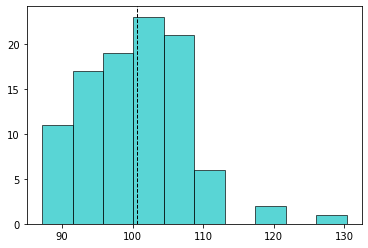

In [27]:
plt.hist(res, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.array(res).mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(100, color='b', linestyle='dashed', linewidth=1)


We now follow similar steps showing bias in inferring $\gamma$. from SLiM simulation We compare results of bottleneck to an "equivalent" constant-size population model.

In [19]:
# constant size population
file = 'data/slim/bgs_3classes/bgs_3classes_N2289_rep{}.trees'
spectra = 'output/constant_spectra_theta250_n{}.bpkl'
res_const = infer_gamma_from_ts(file_temp=file, spectra_temp=spectra, theta_ns=114.45, var='threshold', max_cutoff=30)

In [13]:
# bottleneck
file = 'data/slim/bgs_3classes_noneq/bgs_3classes_bottleneck.3classes.N500rep{}.trees'
spectra = 'output/bottleneck_spectra_theta250_n{}.bpkl'
res = infer_gamma_from_ts(file_temp=file, spectra_temp=spectra, theta_ns=250, var='threshold', max_cutoff=30)

In [14]:
N = 2289
mu = 6.25 * 1e-7
l = 5e5
Ud = mu * l * 4/25

s = -0.1
B = np.exp(Ud / s * 2)
print(f'B =  {B}')
print(f'Ne x s =  {- N * B * s}')

B =  0.36787944117144233
Ne x s =  84.20760408414316


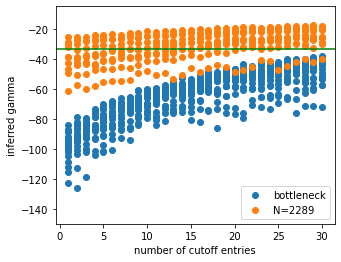

In [24]:
s_focal = -0.02
plt.figure(figsize=(5, 4))
plt.scatter([r[0] for r in res], [- r[1] for r in res], label = 'bottleneck')
plt.scatter([r[0] for r in res_const], [- r[1] for r in res_const], label = 'N=2289')
plt.xlabel("number of cutoff entries")
plt.ylabel("inferred gamma")
plt.ylim(-150, -5)
plt.legend(loc='lower right')
plt.axhline(y = 2 * N * s_focal * B , color='g', linestyle='-')
plt.show()